# 0. Installs/imports

In [1]:
# Install pytorch-geometric
!pip install torch==1.8.1
import torch; print(torch.__version__); print(torch.version.cuda)
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
!pip install torch-geometric
!pip3 install pickle5

     |████████████████████████████████| 804.1MB 21kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
1.8.1+cu102
10.2
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
     |████████████████████████████████| 2.7MB 11.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
     |████████████████████████████████| 1.6MB 13.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
     |████████████████████████████████| 1.1MB 14.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
     |████████████████████████████████| 399kB 12.6MB/s 
     |████████████████████████████████| 225kB 14.4M

In [2]:
# Other imports
import pickle5
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
%matplotlib inline

# 1. Load in data from dataframe and construct graphs.

In [4]:
# Load in our pre-processed dataframe of events
import gnn_tools.data as gnn_data
file_i = 'DataFrameExample.pkl'
data_df = gnn_data.loadData(file_i)

Loading in datafile..
Generating pseudo-mass...
Balancing features...
Done


In [5]:
# Define global features to include in graphs 
global_features=[ 'HT_all',  'mtw', 
                 'nBTags_DL1r_70', 'nJets', 'nRCJetsM100',
                 'Mbb_MinM_DL1r_70', 'Mbbb_Avg_DL1r_70', 
                 'dRbb_MindR_DL1r_70', 'dRbl_MindR_DL1r_70','Centrality_all',
                 'Mjjj_MindR', 
                 'dRjj_Avg', 'Sum__jet_pcb_DL1r_btag_ordered_T__Iteration__6__',
                 'Sum_rcjet_d12', 'Sum_rcjet_d23']

# Define scaling of global features scaled feature[i] = feature[i] / scaling[i]
global_scale = np.asarray([5000000, 1000000 , 
                           8, 20, 5, 
                           1000000, 4000000, 
                           3, 4, 1, 
                           1000000, 
                           3, 30, 
                           1000000, 400000])

# Likewise define scaling of node variables
node_scale=np.asarray([200000,np.pi,np.pi,200000,5,1,1])

# Make sure label and eventNumber are int
data_df['IsSig']=data_df['IsSig'].astype(int)
data_df['eventNumber']=data_df['eventNumber'].astype(int)

# Create training graphs from even eventNumber events and convert to assign to dataset object
graphs, booking = gnn_data.CreateTorchGraphs(data_df.query('eventNumber%2==0'), global_features, global_scale, node_scale)
dataset_train = gnn_data.customDataset(graphs, booking)
# Create training graphs from odd eventNumber events and convert to assign to dataset object
graphs, booking = gnn_data.CreateTorchGraphs(data_df.query('eventNumber%2==1'), global_features, global_scale, node_scale)
dataset_test = gnn_data.customDataset(graphs, booking)

Creating graph data...
5047/5047 complete. Time elapsed: 29.6s,   Estimated time remaining: 0.0s
Done
Creating graph data...
4953/4953 complete. Time elapsed: 28.9s,   Estimated time remaining: 0.0s
Done


In [6]:
# Dataset class has method to save and load from disk
# Important if dataset is large as creating graphs is time costly

# Create directories to save dataset
path_to_save='Example_Graphs'
for suffix in ['Even', 'Odd']:
    os.system('mkdir -p {}_{}'.format(path_to_save, suffix))

# Save each dataset
dataset_train.save_to('{}_{}'.format(path_to_save, 'Even'))
dataset_test.save_to('{}_{}'.format(path_to_save,  'Odd'))

In [7]:
# To load dataset create an empty object and call download_from
dataset_train = gnn_data.customDataset()
dataset_test = gnn_data.customDataset()

path_to_save='Example_Graphs'
dataset_train.download_from('{}_{}'.format(path_to_save, 'Even'))
dataset_test.download_from('{}_{}'.format(path_to_save,  'Odd'))

Done
Done


In [8]:
# Create pytorch dataloader to batch graphs
from torch_geometric.data import DataLoader
loader_train = DataLoader(dataset_train, batch_size=1000, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1000, shuffle=True)

# 2. Define model architecture and begin training

In [9]:
# Get input graph parameters
node_feats_in=dataset_test[0].x.shape[1]
edge_feats_in=dataset_test[0].edge_attr.shape[1]
global_feats_in=dataset_test[0].u.shape[1]+1 # +1 for pseudo mass as additional global
print('Node features:\t\t' ,node_feats_in)
print('Edge features:\t\t' ,edge_feats_in)
print('Global features:\t' ,global_feats_in, '\n')

# Define model and devices
import gnn_tools.model as gnn_model
cuda = torch.device('cuda') # gpu 
cpu = torch.device('cpu') # cpu 
model = gnn_model.GeneralMPGNN(node_feats_in, edge_feats_in, global_feats_in)
model.to(cuda) # move model onto gpu

Node features:		 7
Edge features:		 3
Global features:	 16 



GeneralMPGNN(
  (mp_layer1): MetaLayer(
      edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): Linear(in_features=33, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=6, bias=True)
      (4): ReLU()
    )
  ),
      node_model=NodeModel(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=20, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=12, bias=True)
      (4): ReLU()
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=47, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=12, bias=True)
      (4): ReLU()
    )
  ),
      global_model=GlobalModel(
    (global_mlp): Sequential(
      (0): Linear(in_features=40, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
   

Epoch: 1, 	Training loss: 0.0742,	Test loss: 0.0600, 			Training time: 0.62s, 	Evaluation time: 0.50s, 	Total time elapsed: 1.12s
Test loss improved from inf to 0.0600. Saving model to "bestModel.pt"


Epoch: 2, 	Training loss: 0.0741,	Test loss: 0.0599, 			Training time: 0.60s, 	Evaluation time: 0.51s, 	Total time elapsed: 2.23s
Test loss improved from 0.0600 to 0.0599. Saving model to "bestModel.pt"


Epoch: 3, 	Training loss: 0.0717,	Test loss: 0.0648, 			Training time: 0.60s, 	Evaluation time: 0.49s, 	Total time elapsed: 3.32s
Test loss did not improve.


Epoch: 4, 	Training loss: 0.0739,	Test loss: 0.0602, 			Training time: 0.60s, 	Evaluation time: 0.49s, 	Total time elapsed: 4.42s
Test loss did not improve.


Epoch: 5, 	Training loss: 0.0715,	Test loss: 0.0600, 			Training time: 0.59s, 	Evaluation time: 0.49s, 	Total time elapsed: 5.50s
Test loss did not improve.


Epoch: 6, 	Training loss: 0.0726,	Test loss: 0.0599, 			Training time: 0.60s, 	Evaluation time: 0.48s, 	Total time e

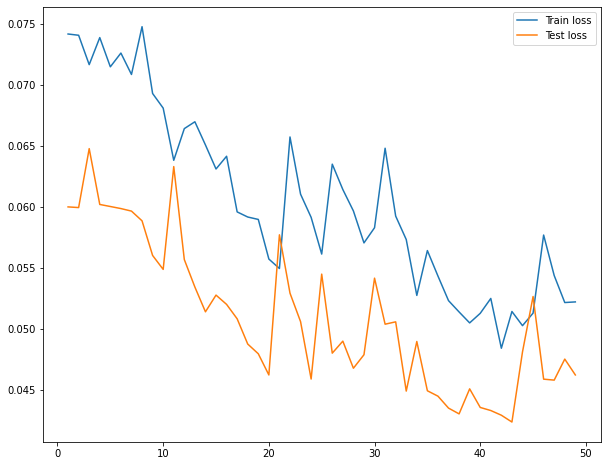

In [10]:
import gnn_tools.train as gnn_train

# Gradient descent method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.999), eps=1e-8, weight_decay=0, amsgrad=False) 
# Loss function
criterion = torch.nn.BCELoss(reduction='none')

# Run full training
model = gnn_train.runTraining(model, loader_train, loader_test, 10, 50, "bestModel.pt", cuda, criterion, optimizer)

# 3. Evaluate performance of GNN model and make plots

In [11]:
# Evaluate model
import gnn_tools.evaluate as gnn_eval

batchsize=1000

# Create dataframe of outputs for training dataset
outputs, labels, weights, bookings = gnn_eval.get_output(dataset_train, model, cuda, cpu, batchsize)
df_train = gnn_eval.get_df_results(bookings, outputs, labels, weights)

# Create dataframe of outputs for testing dataset
outputs, labels, weights, bookings = gnn_eval.get_output(dataset_test, model, cuda, cpu, batchsize)
df_test = gnn_eval.get_df_results(bookings, outputs, labels, weights)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Splitting by background by pseudo_mass


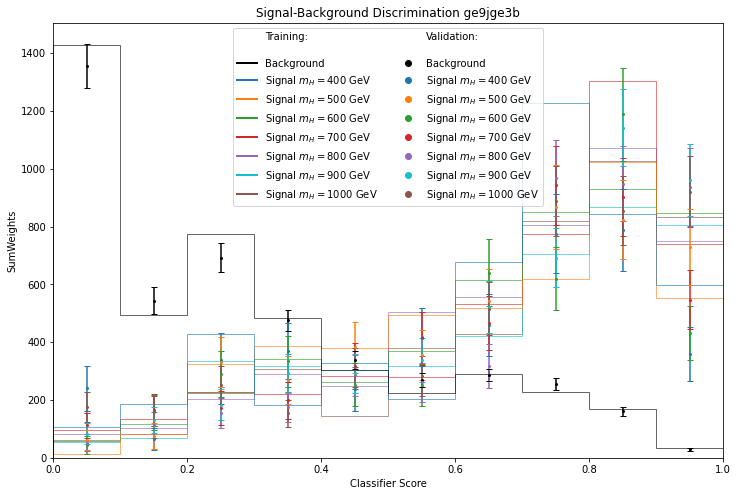

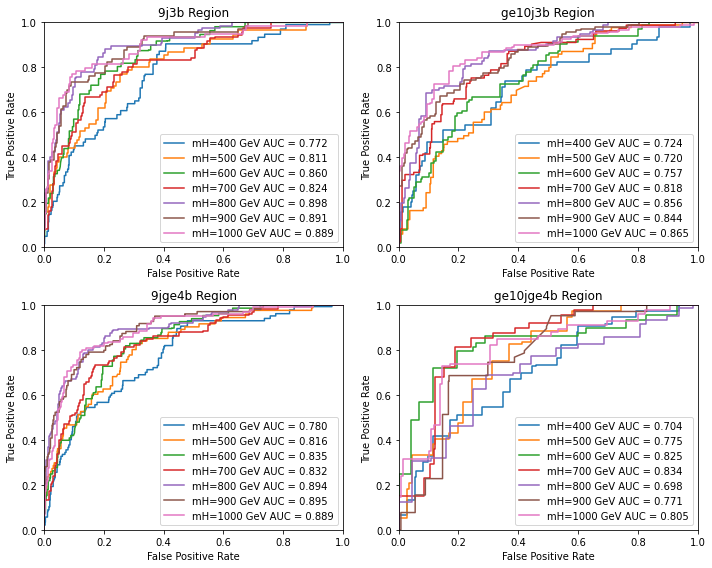

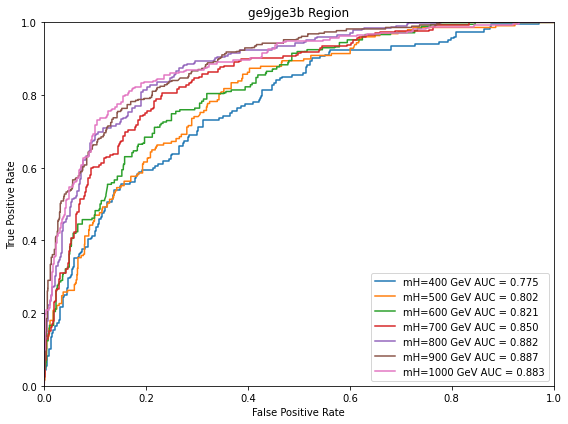

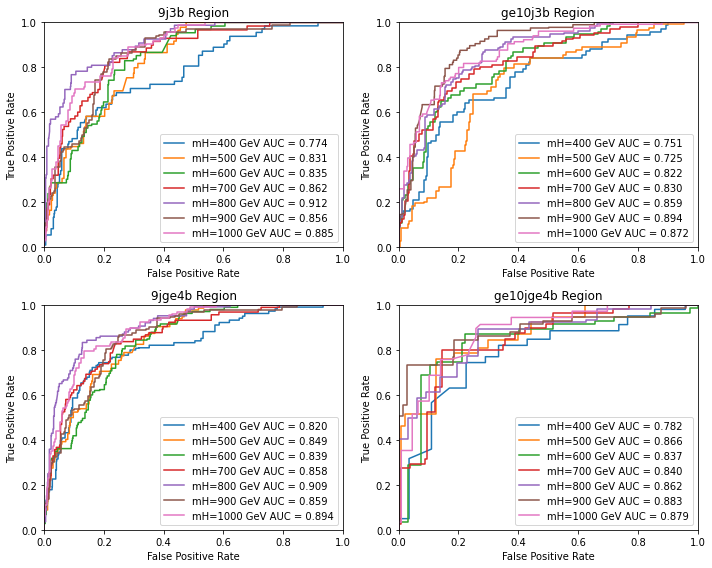

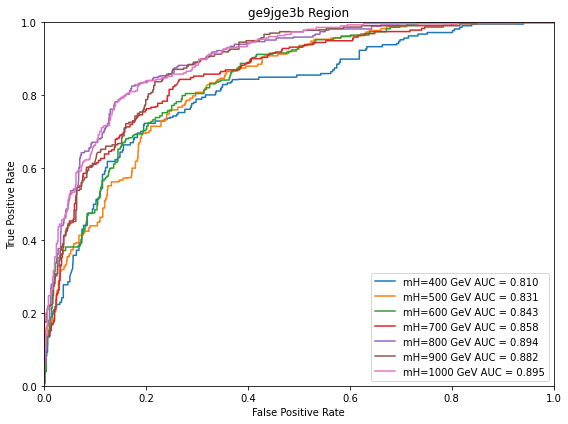

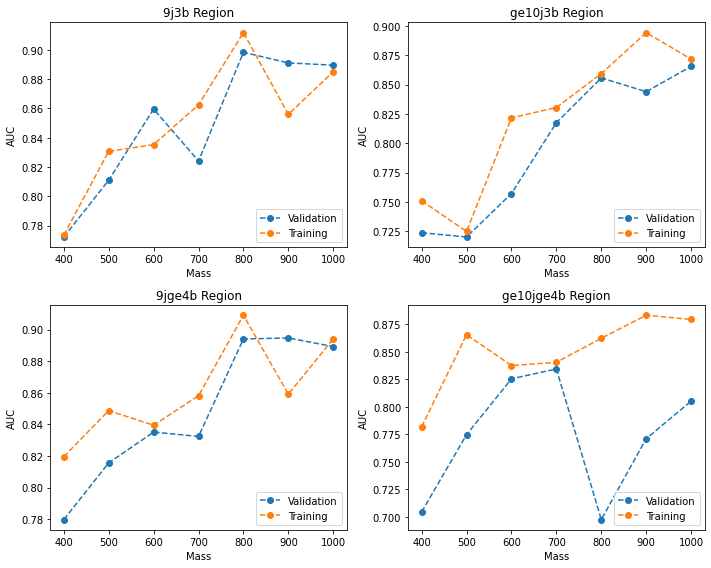

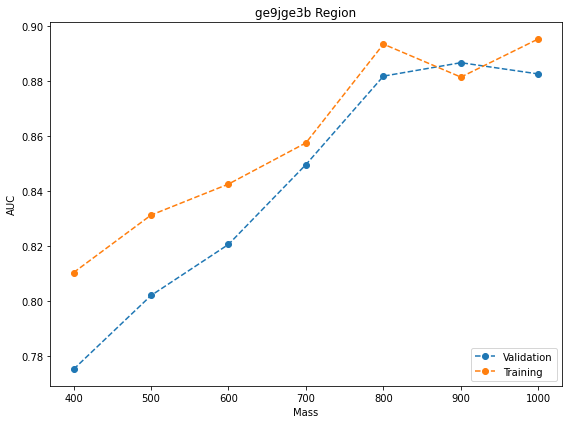

{'ge9jge3b': [0.8103364860847393, 0.8312674923463312, 0.8425643483032064, 0.8575765320115744, 0.8935281647649538, 0.8815243065426395, 0.895423721514423], '9j3b': [0.773558981210861, 0.8307359587310916, 0.8352449030538185, 0.8624048100295114, 0.9116571387049279, 0.8559046598998628, 0.8849990213227497], 'ge10j3b': [0.7510004016381735, 0.7249471473777147, 0.8216598228817691, 0.8304721376546711, 0.8592528415740137, 0.8942370423594129, 0.8717178491517106], '9jge4b': [0.8196526443674065, 0.8487468962409993, 0.8394782253570114, 0.8581612619574418, 0.909125056635606, 0.8591636332232068, 0.8940966641585305], 'ge10jge4b': [0.781855701644155, 0.8655585611227721, 0.8374996859704164, 0.8404332159533532, 0.862315950314797, 0.8832524210213486, 0.8794361069195328]}
{'ge9jge3b': [0.7751181668304192, 0.801987098199844, 0.8205942675015745, 0.8496713686794621, 0.8818706731267738, 0.8867666665656184, 0.8826602639139451], '9j3b': [0.7722992107454154, 0.8109975776333742, 0.8595251613487183, 0.824118960793111

In [13]:
# Plot score histograms, ROC curves and AUC plots
outfile_prefix='Plots'
test_fraction=len(df_test)/(len(df_train)+len(df_test))
aucs_train_split, aucs_test_split = gnn_eval.plotAll(df_train, df_test, test_fraction, outfile_prefix)
print(aucs_train_split)
print(aucs_test_split)